## UMAP colored by cell subtypes

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import colorcet as cc

import cuml
from cuml import PCA, TSNE, UMAP

from synapse_utils import io
from synapse_utils.commons import load_imputed_annotations, log1p_zscore

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
checkpoint_path = '../../output/checkpoint__synapseclr__so3__second_stage'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

# these are pre-computed (can be set to None)
contamination_indices_path = os.path.join(
    checkpoint_path, 'indices', 'contamination_meta_df_row_indices.npy')
reload_epoch = 99
node_idx_list = [0, 1, 2, 3]

In [3]:
imputed_cell_types_df_path = '../../output/consensus/consensus__meta__uncensored.csv'
imputed_meta_ext_df_path = '../../output/gp/synapse_simclr_production/imputed_meta__rbf__synapse_simclr__ensemble.csv'
cell_subtypes_df_path = '../../tables/annotated_synapse_cell_subtypes.csv'

## 2D Embedding

In [4]:
load_prefix = 'encoder.fc'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = False

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

n_pca_components = 128
if n_pca_components < features_nf.shape[-1]:
    features_nf = PCA(n_components=n_pca_components).fit_transform(features_nf)

In [5]:
# load embedding
import pickle

embedding_type = 'UMAP'
features_n2 = np.load(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'))

with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'rb') as f:
    loader = pickle.Unpickler(f)
    umap_2d_fit = loader.load()

## Clustering

In [6]:
# load clustering labels
labels_n = np.load(os.path.join(checkpoint_path, 'indices', f'clustering_labels_n.npy'))
unique_labels = np.unique(labels_n)

Text(0, 0.5, 'UMAP 2')

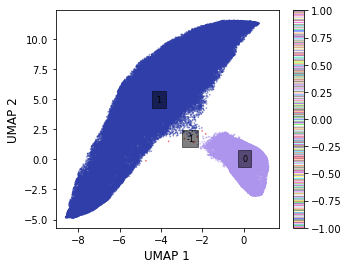

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.5,
    c=labels_n,
    alpha=0.5, cmap=cc.cm.glasbey)

for label_idx in unique_labels:
    x_centroid = np.mean(features_n2[labels_n == label_idx, 0])
    y_centroid = np.mean(features_n2[labels_n == label_idx, 1])
    ax.text(x_centroid, y_centroid, str(label_idx), bbox=dict(facecolor='black', alpha=0.5), fontsize=8)

plt.colorbar(sc)
ax.set_xlabel(f'{embedding_type} 1')
ax.set_ylabel(f'{embedding_type} 2')

In [8]:
# helper function
def get_row_indices_from_synapse_ids(synapse_ids):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

## Load annotations

In [9]:
# which annotations to use?
annotations_to_use = 'imputed'

if annotations_to_use == 'manual':
    analysis_meta_ext_df = meta_ext_df.copy()
    analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['pre_synaptic_volume'].values)
    analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['post_synaptic_volume'].values)
    output_subdir = 'manual/'

elif annotations_to_use == 'imputed':
    analysis_meta_ext_df = load_imputed_annotations(
    meta_df,
    imputed_cell_types_df_path,
    imputed_meta_ext_df_path)
    output_subdir = ''

In [10]:
analysis_synapse_ids = analysis_meta_ext_df['synapse_id'].values
analysis_indices = get_row_indices_from_synapse_ids(analysis_synapse_ids)

## Cell subtypes

In [11]:
cell_subtypes_df = pd.read_csv(cell_subtypes_df_path, index_col=0)

In [12]:
set(cell_subtypes_df['presynaptic_cell_subtype'].values)

{'astrocyte',
 'basket',
 'bipolar',
 'chandelier',
 'martinotti',
 'microglia',
 'neurogliaform',
 'pyramidal',
 'unknown_type'}

In [13]:
set(cell_subtypes_df['postsynaptic_cell_subtype'].values)

{'basket',
 'bipolar',
 'chandelier',
 'martinotti',
 'neurogliaform',
 'pyramidal',
 'unknown_type'}

In [14]:
cell_subtypes_to_label_map = {
    'astrocyte': 'Astrocyte',
    'basket': 'Basket Cell',
    'bipolar': 'Bipolar Cell',
    'chandelier': 'Chandelier Cell',
    'martinotti': 'Martinotti Cell',
    'microglia': 'Microglia',
    'neurogliaform': 'Neurogliaform',
    'pyramidal': 'Pyramidal Cell',
    'unknown_type': 'Unknown'
}

In [15]:
synapse_id_to_pre_cell_subtype_map = {
    synapse_id: presynaptic_cell_subtype
    for synapse_id, presynaptic_cell_subtype in zip(
        cell_subtypes_df['syn_id'],
        cell_subtypes_df['presynaptic_cell_subtype'])}

synapse_id_to_post_cell_subtype_map = {
    synapse_id: postsynaptic_cell_subtype
    for synapse_id, postsynaptic_cell_subtype in zip(
        cell_subtypes_df['syn_id'],
        cell_subtypes_df['postsynaptic_cell_subtype'])}

pre_cell_subtype_array = np.asarray(list(
    map(synapse_id_to_pre_cell_subtype_map.get, meta_df['synapse_id'].values)))

post_cell_subtype_array = np.asarray(list(
    map(synapse_id_to_post_cell_subtype_map.get, meta_df['synapse_id'].values)))

## Plot UMAP

In [16]:
# cell subtypes to plot
all_cell_subtypes = {
    'pyramidal': 'Pyramidal Cell',
    'basket': 'Basket Cell',
    'chandelier': 'Chandelier Cell',
    'martinotti': 'Martinotti Cell',
    'bipolar': 'Bipolar Cell',
    'unknown_type': 'Unknown'
}

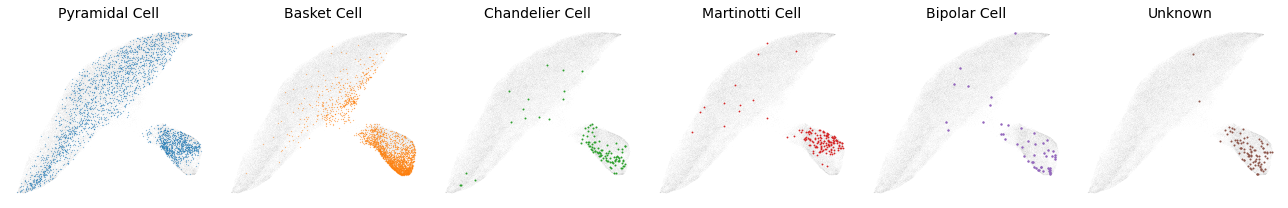

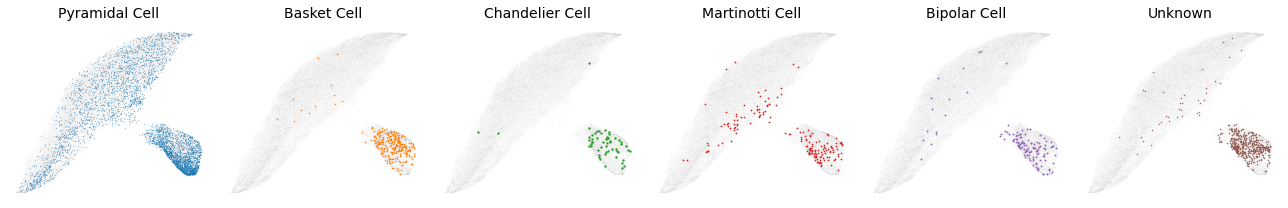

In [17]:
ncols = 6
nrows = int(np.ceil(len(all_cell_subtypes) / ncols))
scale = 3.

s_bg = 0.05
alpha_bg = 0.03
color_bg = 'gray'

s_fg = .05
alpha_fg = 1.

for polarity in ['pre', 'post']:

    # what to show?
    show_mask = np.ones_like(labels_n).astype(bool)
    cell_subtype_array = {
        'pre': pre_cell_subtype_array,
        'post': post_cell_subtype_array}[polarity]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(scale * ncols, scale * nrows))


    for i, cell_subtype in enumerate(all_cell_subtypes):
        ax = axs.flatten()[i]

        # background
        ax.scatter(
            features_n2[show_mask, 0],
            features_n2[show_mask, 1],
            s=s_bg,
            alpha=alpha_bg,
            color=color_bg,
            rasterized=True)

        # foreground
        color_fg = cc.glasbey_category10[i]
        cell_subtype_mask = (cell_subtype_array == cell_subtype) & show_mask
        ax.scatter(
            features_n2[cell_subtype_mask, 0],
            features_n2[cell_subtype_mask, 1],
            s=s_fg * 2000 / np.sum(cell_subtype_mask),
            alpha=alpha_fg,
            color=color_fg,
            rasterized=True)


        ax.axis('off')
        ax.set_title(f'{cell_subtypes_to_label_map[cell_subtype]}', fontsize=14)


    for j in range(i, ncols * nrows):
        ax = axs.flatten()[j]
        ax.axis('off')

    fig.tight_layout()
    fig.savefig(f'../../output/analysis/umap_cell_subtypes/{polarity}_cell_subtype.pdf', facecolor='white', dpi=300)